# Evaluation of A Model

This notebook is intended to bee used for evaluation of a trained model over test dataset. Please change the config dictionary in the begening so that you can evaluate your desired model/sample etc...

In [ ]:
#configure your evalutaion parameters here
_config = {
    'batch_size':1,
    'input_shape_height' : 375,
    'input_shape_width' : 262,
    'model_filename' : 'output/simple_cnn_classification/model_v1.h5',
    'test_sample_filename' : 'data/test/00000000a9764df2_20191005_085442_4.png'
}

In [ ]:
#If you want to disable GPU uncomment here
#import os 
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

---
This section is core global variables to be used during evalutaion

In [ ]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    _ = tf.config.experimental.set_memory_growth(physical_devices[0], True)

#df_train =  pd.read_csv('data/train_labels.csv')
df_test =  pd.read_csv('data/test_labels.csv')

from helpers.decouple import decouple
matrix_test,_ = decouple(df_test)
from helpers.matrix_to_df import matrix_to_df
df_test_agg = matrix_to_df(matrix_test)

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test_agg,
        directory='data/test',
        x_col='filename',
        y_col='class',
        target_size=(_config['input_shape_height'], _config['input_shape_width']),
        batch_size=_config['batch_size'],
        class_mode='categorical')

model = load_model(_config['model_filename'])


In [ ]:
#This section is intented to see overrall performance of the model on the entire test dataset.
#score = model.evaluate_generator(test_generator)
#print(score)

#result = model.predict_generator(test_generator)
#print(result.shape)

---
This section is working on sinlge sample. If you want to examine and explore a specific image on detail.

In [ ]:
test_img = image.load_img(_config['test_sample_filename'],target_size=(_config['input_shape_height'], _config['input_shape_width'],3))
test_img = image.img_to_array(test_img)
test_img_visible = test_img/255
test_img = np.expand_dims(test_img,axis=0)
prediction = model.predict(test_img)

print(list(test_generator.class_indices.keys()))
print(prediction[0])

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].bar(list(test_generator.class_indices.keys()), list(prediction[0]))
ax[1].imshow(test_img_visible)
fig.autofmt_xdate(rotation=45)
plt.show()

---
This section is intented to examine a single random image from the image data generator. Let me explain the plots in detail.

- First we viaully see the sample.
- In the bottom of the image we see bar chart where in the x axis we see the every product label. For each class/product we plot 3 bars.
    - blue bar is the actual perecantage probability value of existance of the product
    - orange is the binary of prediction. Means we assume the probaility of existtance of product is above .5 we set this value as 1.
    - green is the ground truth. It is either 1 or 0
- the last plot is the confusion matrix. It counts the binary prediction and the ground truth how model is confused.


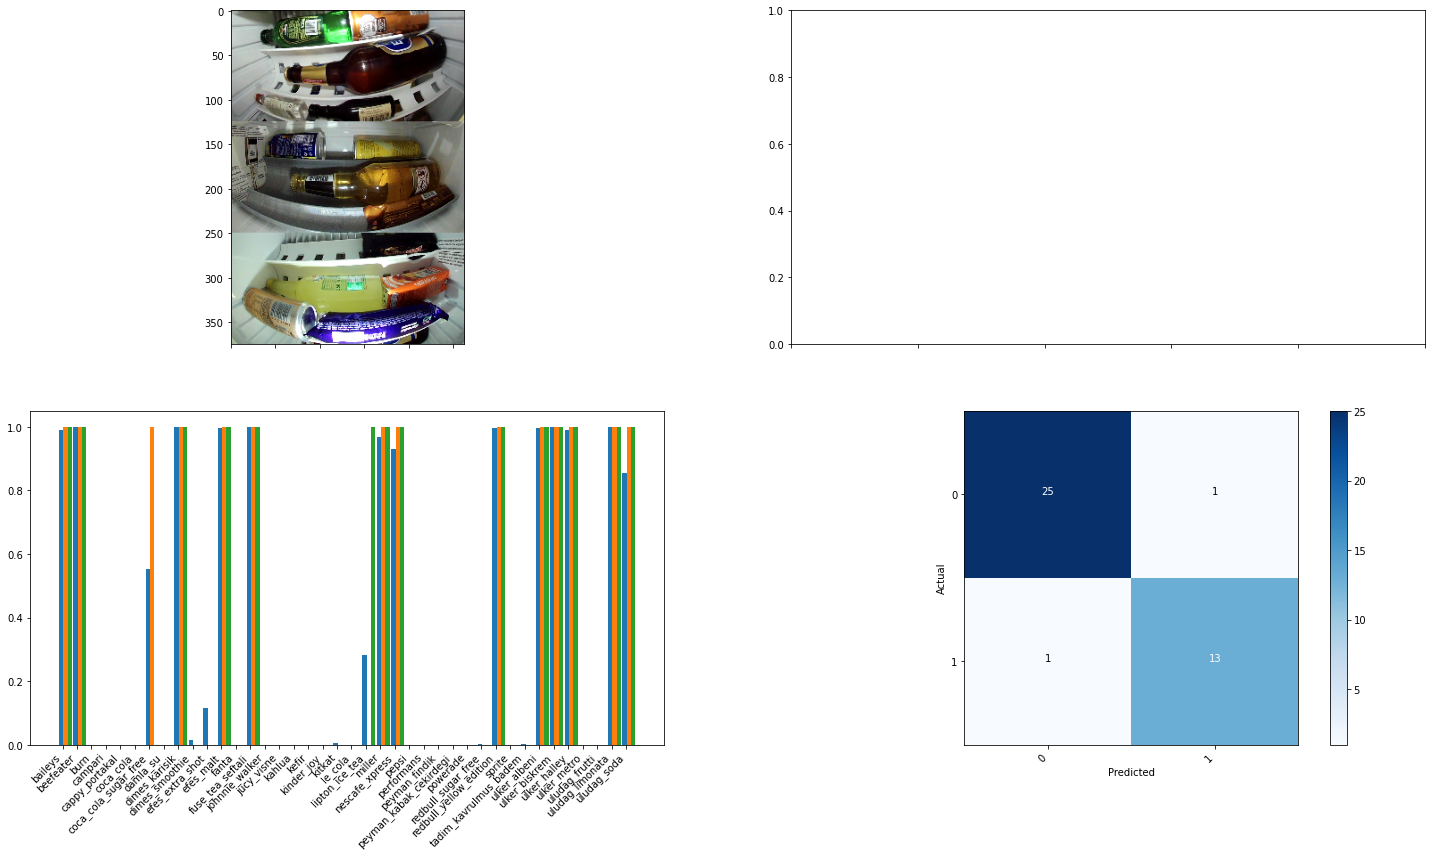

In [120]:
img_batch,ground_truth = test_generator.next()
test_img_visible = img_batch[0].astype('uint8')
prediction = model.predict(img_batch)
prediction_binary = np.round(prediction)

fig, ax = plt.subplots(2,2,figsize=(25,15))

#visualization of sample
ax[0,0].imshow(test_img_visible)

#barchart of prediction binary prediction and ground truth
dim = 3
w = 0.9
dimw = w / dim
x = np.arange(len(list(test_generator.class_indices.keys())))
ax[1,0].bar(x+0*dimw, list(prediction[0]),dimw)
ax[1,0].bar(x+1*dimw, list(prediction_binary[0]),dimw)
ax[1,0].bar(x+2*dimw, list(ground_truth[0]),dimw)
ax[1,0].set_xticks(x + dimw / 3) 
ax[1,0].set_xticklabels(list(test_generator.class_indices.keys()))

#confusion matrix the number of actual and prediction existance counts.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ground_truth[0], np.round(prediction[0]))
cm_plot = ax[1,1].imshow(cm,cmap=plt.cm.Blues,interpolation='nearest')
fig.colorbar(cm_plot,ax=ax[1,1], orientation='vertical')
ax[1,1].set_xlabel('Predicted')
ax[1,1].set_ylabel('Actual')
ax[1,1].set_xticks([0,1])
ax[1,1].set_yticks([0,1])
for i,row in enumerate(cm):
    for j,cell in enumerate(row):
        ax[1,1].text(j,i,format(cm[i,j],'d'),horizontalalignment='center',color='white'if cm[i,j] >cm.max() / 2. else 'black')


fig.autofmt_xdate(rotation=45)
plt.show()